In [85]:
import brightway2 as bw

In [86]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Libaries')

In [87]:
import sensitivity as st
import Monte_Carlo as mc
import reload_lib as rl

In [88]:
# Importing self-made libaries
import standards as s
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp
import reload_lib as rl


lib = [s, mc, lc, lp, bp, st]

In [89]:
# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care'
# Specifying the LCIA method
lcia_method = 'recipe'
rl.reload_lib(lib)

In [90]:
database_name, df_GWP, db_type, flow_legend = st.break_even_initialization(path, lcia_method, lib)
variables = [database_name, df_GWP, db_type, flow_legend]


The chosen project is Diathermy and the chosen database is model
diathermy_CONSQ already exist
Chosen flows:
sc1 SUD - CONSQ
sc3 MUD - CONSQ
Recipe is selected


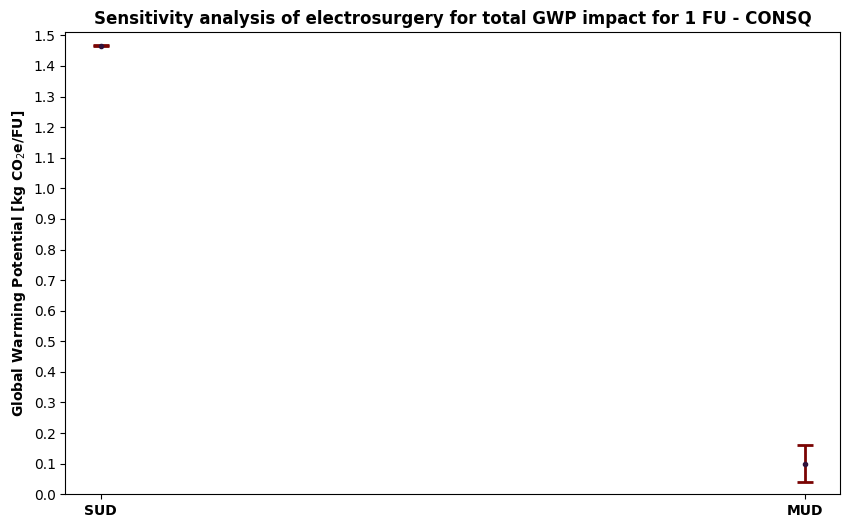

In [95]:
y_min = 0
y_max = 1.5
y_step = 1/10
y_offset = 0.01
rl.reload_lib(lib)
y_axis = [y_min, y_max, y_step, y_offset]
    
df_err = st.uncertainty_graph(variables, lib, y_axis)

In [96]:
df_err

,Raw mat. + prod.,Use,Disinfection,Autoclave,Remanufacturing,Incineration,Avoided energy prod.
SUD,0,0.000724,0,0,0,0,0
MUD,0.036606,0.003005,0,0.002763,0.0,0.018197,-0.000273


In [6]:
rl.reload_lib(lib)
flow_legend, database_name, file_name, sheet_name, save_dir, initialization, file_name_unique, db_type = lc.initilization(path, lcia_method)
# Setting up an empty dictionary with the flows as the key

project_name = initialization[0]
flows = initialization[2]
all_acts, eidb, eidb_db = lc.database_initialization(db_type, database_name, project_name)



size = len(flows)



The chosen project is SU_vs_MU and the chosen database is uncertainty
diathermy_APOS already exist
Chosen flows:
apos


In [7]:
# Obtaining all the product codes for the process'
func_unit = {}
procces_keys = {}

for act in all_acts:
    for proc in range(size):
        if act['name'] == flows[proc]:
            for sub in act.exchanges():
                if sub['type'] == 'technosphere':
                    func_unit[sub.input] = sub['amount']
                    procces_keys[sub.input] = sub.uncertainty
                    # if sub.uncertainty != {}:
                    # procces_keys[flows[proc]].update({sub.input : sub.uncertainty})
               

           

func_unit

{'alubox large + washer - APOS' (unit, GLO, None): 1,
 'H400 REC - APOS' (unit, GLO, None): 1,
 'alubox small + washer - APOS' (unit, GLO, None): 1,
 'alubox small + wipe - APOS' (unit, GLO, None): 1,
 'H400 SU - APOS' (unit, GLO, None): 1,
 'H200 SU - APOS' (unit, GLO, None): 1,
 'alubox large + wipe - APOS' (unit, GLO, None): 1,
 'H200 REC - APOS' (unit, GLO, None): 1}

In [8]:
gwp_cat = lc.lcia_method(initialization[3])
gwp_cat = gwp_cat[1]
gwp_cat

Recipe is selected


('ReCiPe 2016 v1.03, midpoint (H) Runes edition',
 'climate change',
 'global warming potential (GWP1000)')

In [ ]:
from copy import deepcopy as dc
import bw2calc as bc
import numpy as np


func_unit_uncert = dc(func_unit)

lcia_results = {key : [] for key in func_unit.keys()}
results = {key : {} for key in func_unit.keys()}

iterations = 1000
for itt in range(iterations):
    print(f"Iteration {itt + 1} of {iterations}")
    for act, val in func_unit.items():
        # if math.isnan(uncert['loc']) == False and math.isnan(uncert['scale']) == False and func_unit_uncert[key] != {}: 
        uncert = procces_keys[act]
        uncert_val = np.random.lognormal(uncert['scale'], np.exp(uncert['loc']))
        func_unit_uncert[act] = uncert_val
        print(f'Perfoming Monte Carlo  for {act}, val = {uncert_val}')
        # # Use the sampled data in the Monte Carlo LCA

        MC_lca = bc.MonteCarloLCA(func_unit_uncert, gwp_cat)
        MC_lca.lci()

        # Initialize cf_params if not already set
        if not hasattr(MC_lca, 'cf_params'):
            MC_lca.cf_params = MC_lca.load_lcia_data()
            # print('redo cf_params')

        # Rebuild the characterization matrix if it's not already initialized
        if not hasattr(MC_lca, 'characterization_matrix'):
            MC_lca.rebuild_characterization_matrix(MC_lca.method)
            # print('rebuild c matric')

        # Perform LCIA calculation directly
        MC_lca.lcia_calculation()

        results[act].update({f"itteration {itt}" : MC_lca.score})
        # print(act, func_unit_uncert[key][act])
    


In [9]:
import bw2calc as bc



In [17]:
import bw2data as bd
mc_functional_unit, mc_data_objs, _ = bd.prepare_lca_inputs(
    func_unit,
    method=gwp_cat,
)


AttributeError: module 'bw2data' has no attribute 'prepare_lca_inputs'

In [10]:

# 1. Define your foreground system (deterministic)
foreground_demand = {}

for act, val in func_unit.items():
    foreground_demand[(project_name, act)] = val

# 2. Specify the method (e.g., Global Warming Potential, IPCC 2013)

# 3. Create the LCA object with distributions enabled for the background
lca = bc.LCA(demand=func_unit, method=gwp_cat)
lca.lci()
lca.lcia()

# 4. Run the Monte Carlo simulation
iterations = 100  # Number of Monte Carlo runs
results = []

# for _ in range(iterations):
#     lca.redo_lcia()  # Resample the background uncertainty
#     results.append(lca.score)  # Store the impact score for each iteration

# # Results now contain 100 Monte Carlo samples
# print(results)


In [23]:
lca.tech_params

array([(45099, 45099, 40389, 40389, 0, 0, -1.0000e+00,  -1.        ,        nan, nan, nan, nan,  True),
       (45100, 45100, 40390, 40390, 0, 0,  1.0000e+00,   1.        ,        nan, nan, nan, nan, False),
       (45103, 45103, 40391, 40391, 0, 0,  1.0000e+00,   1.        ,        nan, nan, nan, nan, False),
       ...,
       (42970, 45149, 38260, 40425, 1, 2,  3.5439e-11, -24.063208  , 0.23260696, nan, nan, nan, False),
       (44491, 45149, 39781, 40425, 1, 2,  1.5176e+00,   0.41713014, 0.9095603 , nan, nan, nan, False),
       (44506, 45149, 39796, 40425, 1, 2,  3.0409e-10, -21.913698  , 1.3886684 , nan, nan, nan, False)],
      dtype=[('input', '<u4'), ('output', '<u4'), ('row', '<u4'), ('col', '<u4'), ('type', 'u1'), ('uncertainty_type', 'u1'), ('amount', '<f4'), ('loc', '<f4'), ('scale', '<f4'), ('shape', '<f4'), ('minimum', '<f4'), ('maximum', '<f4'), ('negative', '?')])